# Score-based Generative Modeling with SDEs (Simple examples)

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import lib.toy_data as toy_data
import numpy as np

Basic parameters

In [2]:
learning_rate = 1e-3 # learning rate for training neural network
batch_size = 256  # batch size during training of neural network
epochs = 100000   # Number of training epochs for the neural network
T = 5    # Forward simulation time in the forward SDE
dataset = 'moons' # Dataset choice, see toy_data for full options of toy datasets ('checkerboard','8gaussians','2spirals','swissroll','moons',etc.)

We first initialize the neural net that models the score function. 

In [3]:
## Model construction

class DenoisingModel(nn.Module):
    
    def __init__(self, hidden_units=32):
        super(DenoisingModel, self).__init__()
        # hidden_units = 32
        
        # data and timestep
        self.fc1 = nn.Linear(3, int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc1.weight)
        self.activation1 = nn.GELU()
        self.fc2 = nn.Linear(int(hidden_units), int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc2.weight)
        self.activation2 = nn.GELU()
        self.fc3 = nn.Linear(int(hidden_units), 3, bias=True)
        nn.init.xavier_uniform_(self.fc3.weight)
        self.activation3 = nn.GELU()
        
        self.fc4 = nn.Linear(3, int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc4.weight)
        self.activation4 = nn.GELU()
        self.fc5 = nn.Linear(int(hidden_units), int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc5.weight)
        self.activation5 = nn.GELU()
        self.fc6 = nn.Linear(int(hidden_units), 3, bias=True)
        nn.init.xavier_uniform_(self.fc6.weight)
        self.activation6 = nn.GELU()
        
        self.fc7 = nn.Linear(3, int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc7.weight)
        self.activation7 = nn.GELU()
        self.fc8 = nn.Linear(int(hidden_units), int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc8.weight)
        self.activation8 = nn.GELU()
        self.fc9 = nn.Linear(int(hidden_units), 2, bias=True)
        nn.init.xavier_uniform_(self.fc9.weight)
        
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = self.fc3(x)
        x = self.activation3(x)
        x = self.fc4(x)
        x = self.activation4(x)
        x = self.fc5(x)
        x = self.activation5(x)
        x = self.fc6(x)
        x = self.activation6(x)
        x = self.fc7(x)
        x = self.activation7(x)
        x = self.fc8(x)
        x = self.activation8(x)
        x = self.fc9(x)
        
        return x
      
scorenet = DenoisingModel()
print(scorenet)
optimizer = optim.Adam(scorenet.parameters(), lr=learning_rate)

DenoisingModel(
  (fc1): Linear(in_features=3, out_features=32, bias=True)
  (activation1): GELU(approximate='none')
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (activation2): GELU(approximate='none')
  (fc3): Linear(in_features=32, out_features=3, bias=True)
  (activation3): GELU(approximate='none')
  (fc4): Linear(in_features=3, out_features=32, bias=True)
  (activation4): GELU(approximate='none')
  (fc5): Linear(in_features=32, out_features=32, bias=True)
  (activation5): GELU(approximate='none')
  (fc6): Linear(in_features=32, out_features=3, bias=True)
  (activation6): GELU(approximate='none')
  (fc7): Linear(in_features=3, out_features=32, bias=True)
  (activation7): GELU(approximate='none')
  (fc8): Linear(in_features=32, out_features=32, bias=True)
  (activation8): GELU(approximate='none')
  (fc9): Linear(in_features=32, out_features=2, bias=True)
)


Define loss functions. These loss functions assume that the forward process is a standard OU process dx = -x/2 dt + dW. The choice of \lambda(t) in the SGM objective function is equal to 1 (the constant in front of the dW term). 

In [4]:
# Loss function -- we use the denoising diffusions objective function
# Scorenet is the score model, samples are the training samples, Tmin/Tmax are the time interval that is being trained on, and eps is so that Tmin is not sampled. 

def time_dsm_score_estimator(scorenet,samples,Tmin,Tmax,eps):

    t = torch.rand(samples.shape[0]) * (Tmax - Tmin - eps) + eps + Tmin # sample uniformly from time interval

    # Add noise to the training samples
    sigmas = torch.sqrt(1 - torch.exp(-t))
    sigmas = sigmas.view(samples.shape[0],*([1]*len(samples.shape[1:])))
    noise = torch.randn_like(samples) * sigmas
    tenlarge = t.repeat(2,1).T
    perturbed_samples = samples * torch.exp(-0.5 * tenlarge) + noise

    # Evaluate score and marginal score on the perturbed samples
    target = - 1/ (sigmas ** 2) * (noise)
    score_eval_samples = torch.cat((t.reshape(-1,1),perturbed_samples),1)
    scores = scorenet(score_eval_samples)

    # Evaluate the loss function 
    target = target.view(target.shape[0],-1)
    scores = scores.view(scores.shape[0],-1)
    loss = 0.5 * ((scores-target) ** 2).sum(dim = -1) 

    return loss.mean(dim = 0)


# Loss function
# This is for if you have a specific mesh for the time interval you would like the network to train on. 
def deterministic_time_dsm_score_estimator(scorenet,samples,t):

    loss = 0
    for ii in range(len(t)-1):

        # Add noise to the training samples
        sigmas = torch.sqrt(1 - torch.exp(-t[ii]))
        noise = torch.randn_like(samples) * sigmas
        perturbed_samples = samples * torch.exp(-0.5 * t[ii]) + noise

        # Evaluate score and marginal score on perturbed samples
        target = - 1/ (sigmas ** 2) * (noise)
        score_eval_samples = torch.cat((t[ii].repeat(perturbed_samples.shape[0],1),perturbed_samples),1)
        scores = scorenet(score_eval_samples)

        # Evaluate loss function at this particular t[ii]
        target = target.view(target.shape[0],-1)
        scores = scores.view(scores.shape[0],-1)
        loss_vec = 0.5 * ((scores-target) ** 2).sum(dim = -1) 
        loss = loss + (t[ii+1]-t[ii])*loss_vec.mean(dim = 0)

    return loss


Training the score network

In [5]:
# Training the score network

for step in range(epochs):
    # sample toy_data
    p_samples = toy_data.inf_train_gen(dataset, batch_size)
    samples = torch.tensor(p_samples).to(dtype = torch.float32)

    # evaluate loss function and gradient
    loss = time_dsm_score_estimator(scorenet,samples,0,T,eps = 0.0001)
    optimizer.zero_grad()
    loss.backward()

    # Update score network
    optimizer.step()

    if not step%100:
        print(loss,step)




tensor(1.6600, grad_fn=<MeanBackward1>) 0
tensor(1.7359, grad_fn=<MeanBackward1>) 100
tensor(1.2994, grad_fn=<MeanBackward1>) 200
tensor(0.9481, grad_fn=<MeanBackward1>) 300
tensor(0.9368, grad_fn=<MeanBackward1>) 400
tensor(0.9310, grad_fn=<MeanBackward1>) 500
tensor(0.5081, grad_fn=<MeanBackward1>) 600
tensor(0.9030, grad_fn=<MeanBackward1>) 700
tensor(1.4139, grad_fn=<MeanBackward1>) 800
tensor(0.8136, grad_fn=<MeanBackward1>) 900
tensor(1.0074, grad_fn=<MeanBackward1>) 1000
tensor(6.7275, grad_fn=<MeanBackward1>) 1100
tensor(0.5036, grad_fn=<MeanBackward1>) 1200
tensor(2.1299, grad_fn=<MeanBackward1>) 1300
tensor(15.9936, grad_fn=<MeanBackward1>) 1400
tensor(3.9594, grad_fn=<MeanBackward1>) 1500
tensor(1.0345, grad_fn=<MeanBackward1>) 1600
tensor(2.3584, grad_fn=<MeanBackward1>) 1700
tensor(0.9626, grad_fn=<MeanBackward1>) 1800
tensor(1.9552, grad_fn=<MeanBackward1>) 1900
tensor(1.0330, grad_fn=<MeanBackward1>) 2000
tensor(0.8057, grad_fn=<MeanBackward1>) 2100
tensor(0.6663, grad_f

SDE simulation functions

In [6]:
# This is the solving the OU process exactly given deterministic initial conditions
def ou_dynamics(init, T):
    init = init * torch.exp(- 0.5 * T) + torch.sqrt(1-torch.exp(-T)) * torch.randn_like(init)
    return init

def reverse_sde(score, init,T,lr=0.01):
    step = int(T/lr) 
    for i in range(step,-1,-1):
        current_lr = lr
        evalpoint = torch.cat(((torch.tensor(lr*i)).repeat(init.shape[0],1),init),1)
        init = init + current_lr  * (init/2 + score(evalpoint).detach() )
        init = init + torch.randn_like(init) * np.sqrt(current_lr)
    return init


# The following is the deterministic ODE flow that can also sample from the target distribution

def reverse_ode_flow(score,init,T,lr = 0.01):
    step = int(T/lr)
    for i in range(step,-1,-1):
        current_lr = lr
        evalpoint = torch.cat(((torch.tensor(lr*i)).repeat(init.shape[0],1),init),1)
        init = init + current_lr  * (init/2 + 1/2 * score(evalpoint).detach() )
    return init

Sample using the score network 

In [7]:
# Denoising the normal distribution 
samples_lang = torch.randn(10000, 2) # * (right_bound - left_bound) + left_bound
samples_lang = reverse_sde(scorenet, samples_lang,torch.tensor(T)).detach().numpy()


# Denoising samples from the training data
samples = torch.tensor(toy_data.inf_train_gen('moons', batch_size = 10000))
samples_lang_noisedtraining = samples * torch.exp(-0.5 * torch.tensor(T)) + torch.sqrt(1-torch.exp(-torch.tensor(T))) * torch.randn_like(samples)
samples_lang_noisedtraining =reverse_sde(scorenet, samples_lang_noisedtraining.to(dtype=torch.float32),torch.tensor(T)).detach().numpy()

# Deterministically evolving the normal distribution 
samples_lang_deterministic = torch.randn(10000,2)
samples_lang_deterministic = reverse_ode_flow(scorenet,samples_lang_deterministic,torch.tensor(T)).detach().numpy()

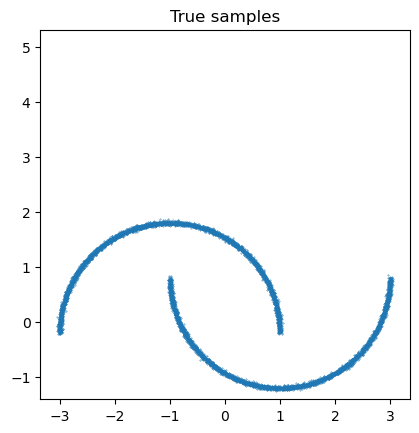

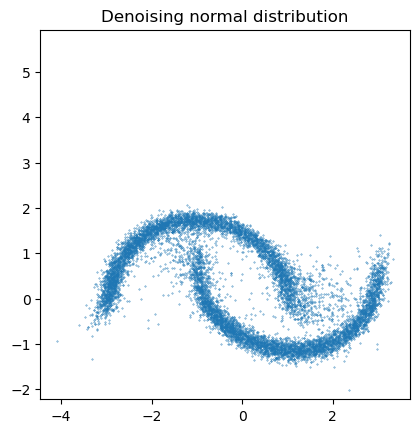

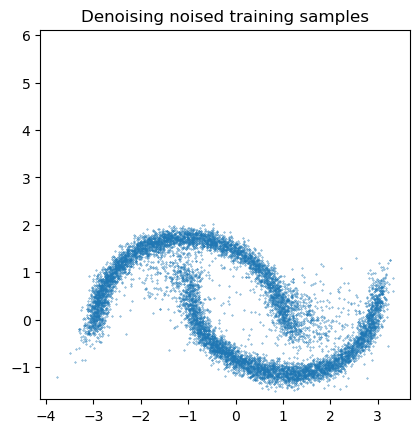

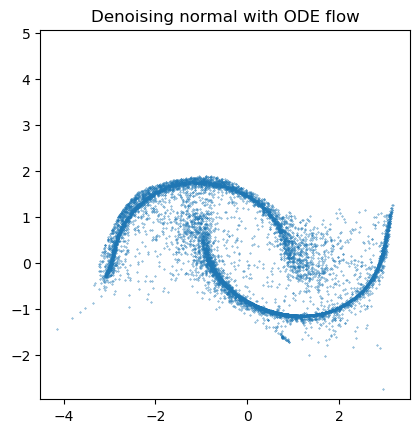

In [8]:
plt.clf()
p_samples = toy_data.inf_train_gen(dataset, batch_size = 10000)
samples_true = torch.tensor(p_samples).to(dtype = torch.float32)
plt.scatter(samples_true[:,0],samples_true[:,1],s = 0.1)
plt.axis('square')
plt.title('True samples')
plt.show()


plt.clf()
plt.scatter(samples_lang[:,0],samples_lang[:,1],s = 0.1)
plt.axis('square')
plt.title('Denoising normal distribution')
plt.show()


plt.clf()
plt.scatter(samples_lang_noisedtraining[:,0],samples_lang_noisedtraining[:,1],s = 0.1)
plt.axis('square')
plt.title('Denoising noised training samples')
plt.show()


plt.clf()
plt.scatter(samples_lang_deterministic[:,0],samples_lang_deterministic[:,1],s = 0.1)
plt.axis('square')
plt.title('Denoising normal with ODE flow')
plt.show()